In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl

from pandas.tseries.frequencies import to_offset
from matplotlib.patches import Patch

mpl.rcParams['figure.dpi']= 800
plt.rcParams["font.family"] = "Times New Roman"
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#FF5F05", "#13294B", "#009FD4", "#FCB316", "#006230", "#007E8E", "#5C0E41", "#7D3E13"])

In [2]:
df_rain = pd.read_csv('./data/processed/IMERGDP/IMERGDP_summary.csv')
df_soil = pd.read_csv('./data/processed/SMAP/SMAP_summary.csv')

df_rain['date'] = pd.to_datetime(df_rain['date'])
df_soil['date'] = pd.to_datetime(df_soil['date'])

df_rain = df_rain.set_index('date')
df_soil = df_soil.set_index('date')

In [3]:
df_soil['sm'] = df_soil['sm'].interpolate(method='linear')
df_soil = df_soil.dropna(subset=['sm'])
df_soil['sm'] = df_soil['sm'] * 100

In [4]:
AM_filter = df_soil['pass'] == 'AM'
PM_filter = df_soil['pass'] == 'PM'
nan_filter = df_soil['quality'] != 0

In [5]:
season_colors = {
    "Winter": "C1",
    "Spring": "C4",
    "Summer": "C3",
    "Autumn": "C7"
}

outlier_props = dict(markerfacecolor='black', marker='D', markersize=2)

def get_season(dt):
    m = dt.month
    if m in [12, 1, 2]:
        return "Winter"
    elif m in [3, 4, 5]:
        return "Spring"
    elif m in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

def event_finder(df_rain, wet_thresh=1.0, start_thresh=5.0, lookahead_days=2):
    r = df_rain.copy().sort_index()
    if not isinstance(r.index, pd.DatetimeIndex):
        r.index = pd.to_datetime(r.index)

    r['wet'] = r['precipitation'] >= wet_thresh
    run_change = r['wet'] != r['wet'].shift(fill_value=False)
    r['run_id'] = run_change.cumsum()

    records = []
    for rid, g in r[r['wet']].groupby('run_id'):
        start_date = g.index[0]
        end_date   = g.index[-1]
        # Only consider runs that start after a dry day
        prev_day = start_date - pd.Timedelta(days=1)
        prev_dry = (prev_day not in r.index) or (r.loc[prev_day, 'precipitation'] < wet_thresh)

        # Check if a ≥ start_thresh day occurs within the first L days of the run
        head = g.iloc[:lookahead_days]  # e.g., first 2 days
        has_burst_early = (head['precipitation'] >= start_thresh).any()
        # Or the very first day already meets start_thresh
        first_is_burst = g['precipitation'].iloc[0] >= start_thresh

        if prev_dry and (first_is_burst or has_burst_early):
            records.append({
                'start': start_date.normalize(),
                'end': end_date.normalize(),
                'total_rain': g['precipitation'].sum(),
                'days': len(g)
            })

    events = pd.DataFrame.from_records(records).sort_values('start').reset_index(drop=True)
    return events

events = event_finder(df_rain)
events_describe = events.loc[:, ['total_rain', 'days']].describe()
events['season'] = events['start'].map(get_season)
events.head(3)

,start,end,total_rain,days,season
0,2022-01-09,2022-01-09,10.170556,1,Winter
1,2022-01-15,2022-01-15,6.509444,1,Winter
2,2022-01-20,2022-01-21,15.420555,2,Winter


In [6]:
def compute_event_metrics(events: pd.DataFrame, df_soil: pd.DataFrame) -> pd.DataFrame:
    # Ensure dtypes
    ev = events.copy()
    ev['start'] = pd.to_datetime(ev['start']).dt.normalize()
    ev['end']   = pd.to_datetime(ev['end']).dt.normalize()
    ev = ev.sort_values(['start', 'end']).reset_index(drop=True)

    soil = df_soil.copy()
    # index must be datetime
    soil = soil.sort_index()
    if not isinstance(soil.index, pd.DatetimeIndex):
        soil.index = pd.to_datetime(soil.index)

    # Convenience offsets
    one_day = to_offset("1D")
    three_days = to_offset("3D")

    # Precompute next/prev event dates
    ev['prev_end']  = ev['end'].shift(1)
    ev['next_start'] = ev['start'].shift(-1)

    # Output columns
    out_cols = [
        'antecedent_sm','antecedent_start','antecedent_end','antecedent_time',
        'max_sm','max_time','delta_sm','lag_days','post_window_days_used'
    ]
    for c in out_cols:
        ev[c] = pd.NA

    # Iterate events (93 rows → fast enough; keeps logic clear)
    for i, row in ev.iterrows():
        start = row['start']                # midnight of start day
        end   = row['end'] + one_day - pd.Timedelta(seconds=1)  # end-of-day inclusive

        # ---------- Antecedent window (3 days before start, trimmed after previous event) ----------
        ant_start_nominal = start - three_days
        ant_end = start - pd.Timedelta(seconds=1)  # up to just before event day starts

        if pd.notna(row['prev_end']):
            # "pick the day after" previous event end
            prev_end_day_after = (row['prev_end'] + one_day)
            # antecedent window starts at the later of nominal start or day after prev_end
            ant_start = max(ant_start_nominal, prev_end_day_after)
        else:
            ant_start = ant_start_nominal

        # Select soil samples in antecedent window [ant_start, ant_end]
        ant_mask = (soil.index >= ant_start) & (soil.index <= ant_end)
        ant_df = soil.loc[ant_mask]

        if not ant_df.empty:
            antecedent_sm = ant_df['sm'].mean()
            # For lag reference time, use the **last** soil sample within antecedent window
            antecedent_time = ant_df.index.max()
        else:
            antecedent_sm = pd.NA
            antecedent_time = pd.NaT

        # ---------- Response (max) window = [event_start, event_end + 3d], clipped before next event ----------
        post_end_nominal = (row['end'] + three_days + one_day - pd.Timedelta(seconds=1))  # include 3 full days after end
        if pd.notna(row['next_start']):
            # prevent overlap: stop at the day before next event starts
            next_start_minus = row['next_start'] - pd.Timedelta(seconds=1)
            resp_end = min(post_end_nominal, next_start_minus)
        else:
            resp_end = post_end_nominal

        # Full response search window includes the event itself:
        resp_start = start
        resp_mask = (soil.index >= resp_start) & (soil.index <= resp_end)
        resp_df = soil.loc[resp_mask]

        if not resp_df.empty:
            # Soil moisture maximum and its time
            max_idx = resp_df['sm'].idxmax()
            max_sm = float(resp_df.at[max_idx, 'sm'])
            max_time = max_idx
        else:
            max_sm = pd.NA
            max_time = pd.NaT

        # ---------- Derived metrics ----------
        if pd.notna(antecedent_sm) and pd.notna(max_sm):
            delta_sm = float(max_sm) - float(antecedent_sm)
        else:
            delta_sm = pd.NA

        if pd.notna(antecedent_time) and pd.notna(max_time):
            lag_days = (max_time - antecedent_time) / pd.Timedelta(days=1)
            lag_days = float(lag_days)
        else:
            lag_days = pd.NA

        # Store
        ev.at[i, 'antecedent_sm']   = float(antecedent_sm) if antecedent_sm is not pd.NA else pd.NA
        ev.at[i, 'antecedent_start'] = ant_start
        ev.at[i, 'antecedent_end']   = ant_end
        ev.at[i, 'antecedent_time']  = antecedent_time

        ev.at[i, 'max_sm']  = max_sm
        ev.at[i, 'max_time'] = max_time

        ev.at[i, 'delta_sm'] = delta_sm
        ev.at[i, 'lag_days'] = lag_days

        # How many post-event days actually used (for QC/context)
        post_used = (resp_end.normalize() - row['end']).days
        ev.at[i, 'post_window_days_used'] = int(max(post_used, 0))

    # Tidy types
    ev['antecedent_start'] = pd.to_datetime(ev['antecedent_start'])
    ev['antecedent_end']   = pd.to_datetime(ev['antecedent_end'])
    ev['antecedent_time']  = pd.to_datetime(ev['antecedent_time'])
    ev['max_time']         = pd.to_datetime(ev['max_time'])
    ev['post_window_days_used'] = ev['post_window_days_used'].astype('Int64')

    # Optional: reorder columns
    metric_cols = [
        'antecedent_sm','max_sm','delta_sm','lag_days',
        'antecedent_start','antecedent_end','antecedent_time','max_time',
        'post_window_days_used'
    ]
    ordered = ev.columns[:5].tolist() + metric_cols  # keep original first 5 cols
    ev = ev[ordered]

    return ev

In [7]:
print(events.shape)
events['season'].value_counts()

(114, 5)


season
Winter    31
Spring    31
Summer    29
Autumn    23
Name: count, dtype: int64

In [8]:
df_monthly = pd.concat([
    df_rain.resample('ME').sum(),
    df_soil.resample('ME').agg({
        'sm': 'mean',
        'quality': 'sum'
    })
], axis=1)
# Set index to first day of each month
df_monthly.index = df_monthly.index.map(lambda x: x.replace(day=1))
df_monthly['season'] = df_monthly.index.map(get_season)

C:\Users\alihg\AppData\Local\Temp\ipykernel_16460\1826705928.py:46: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


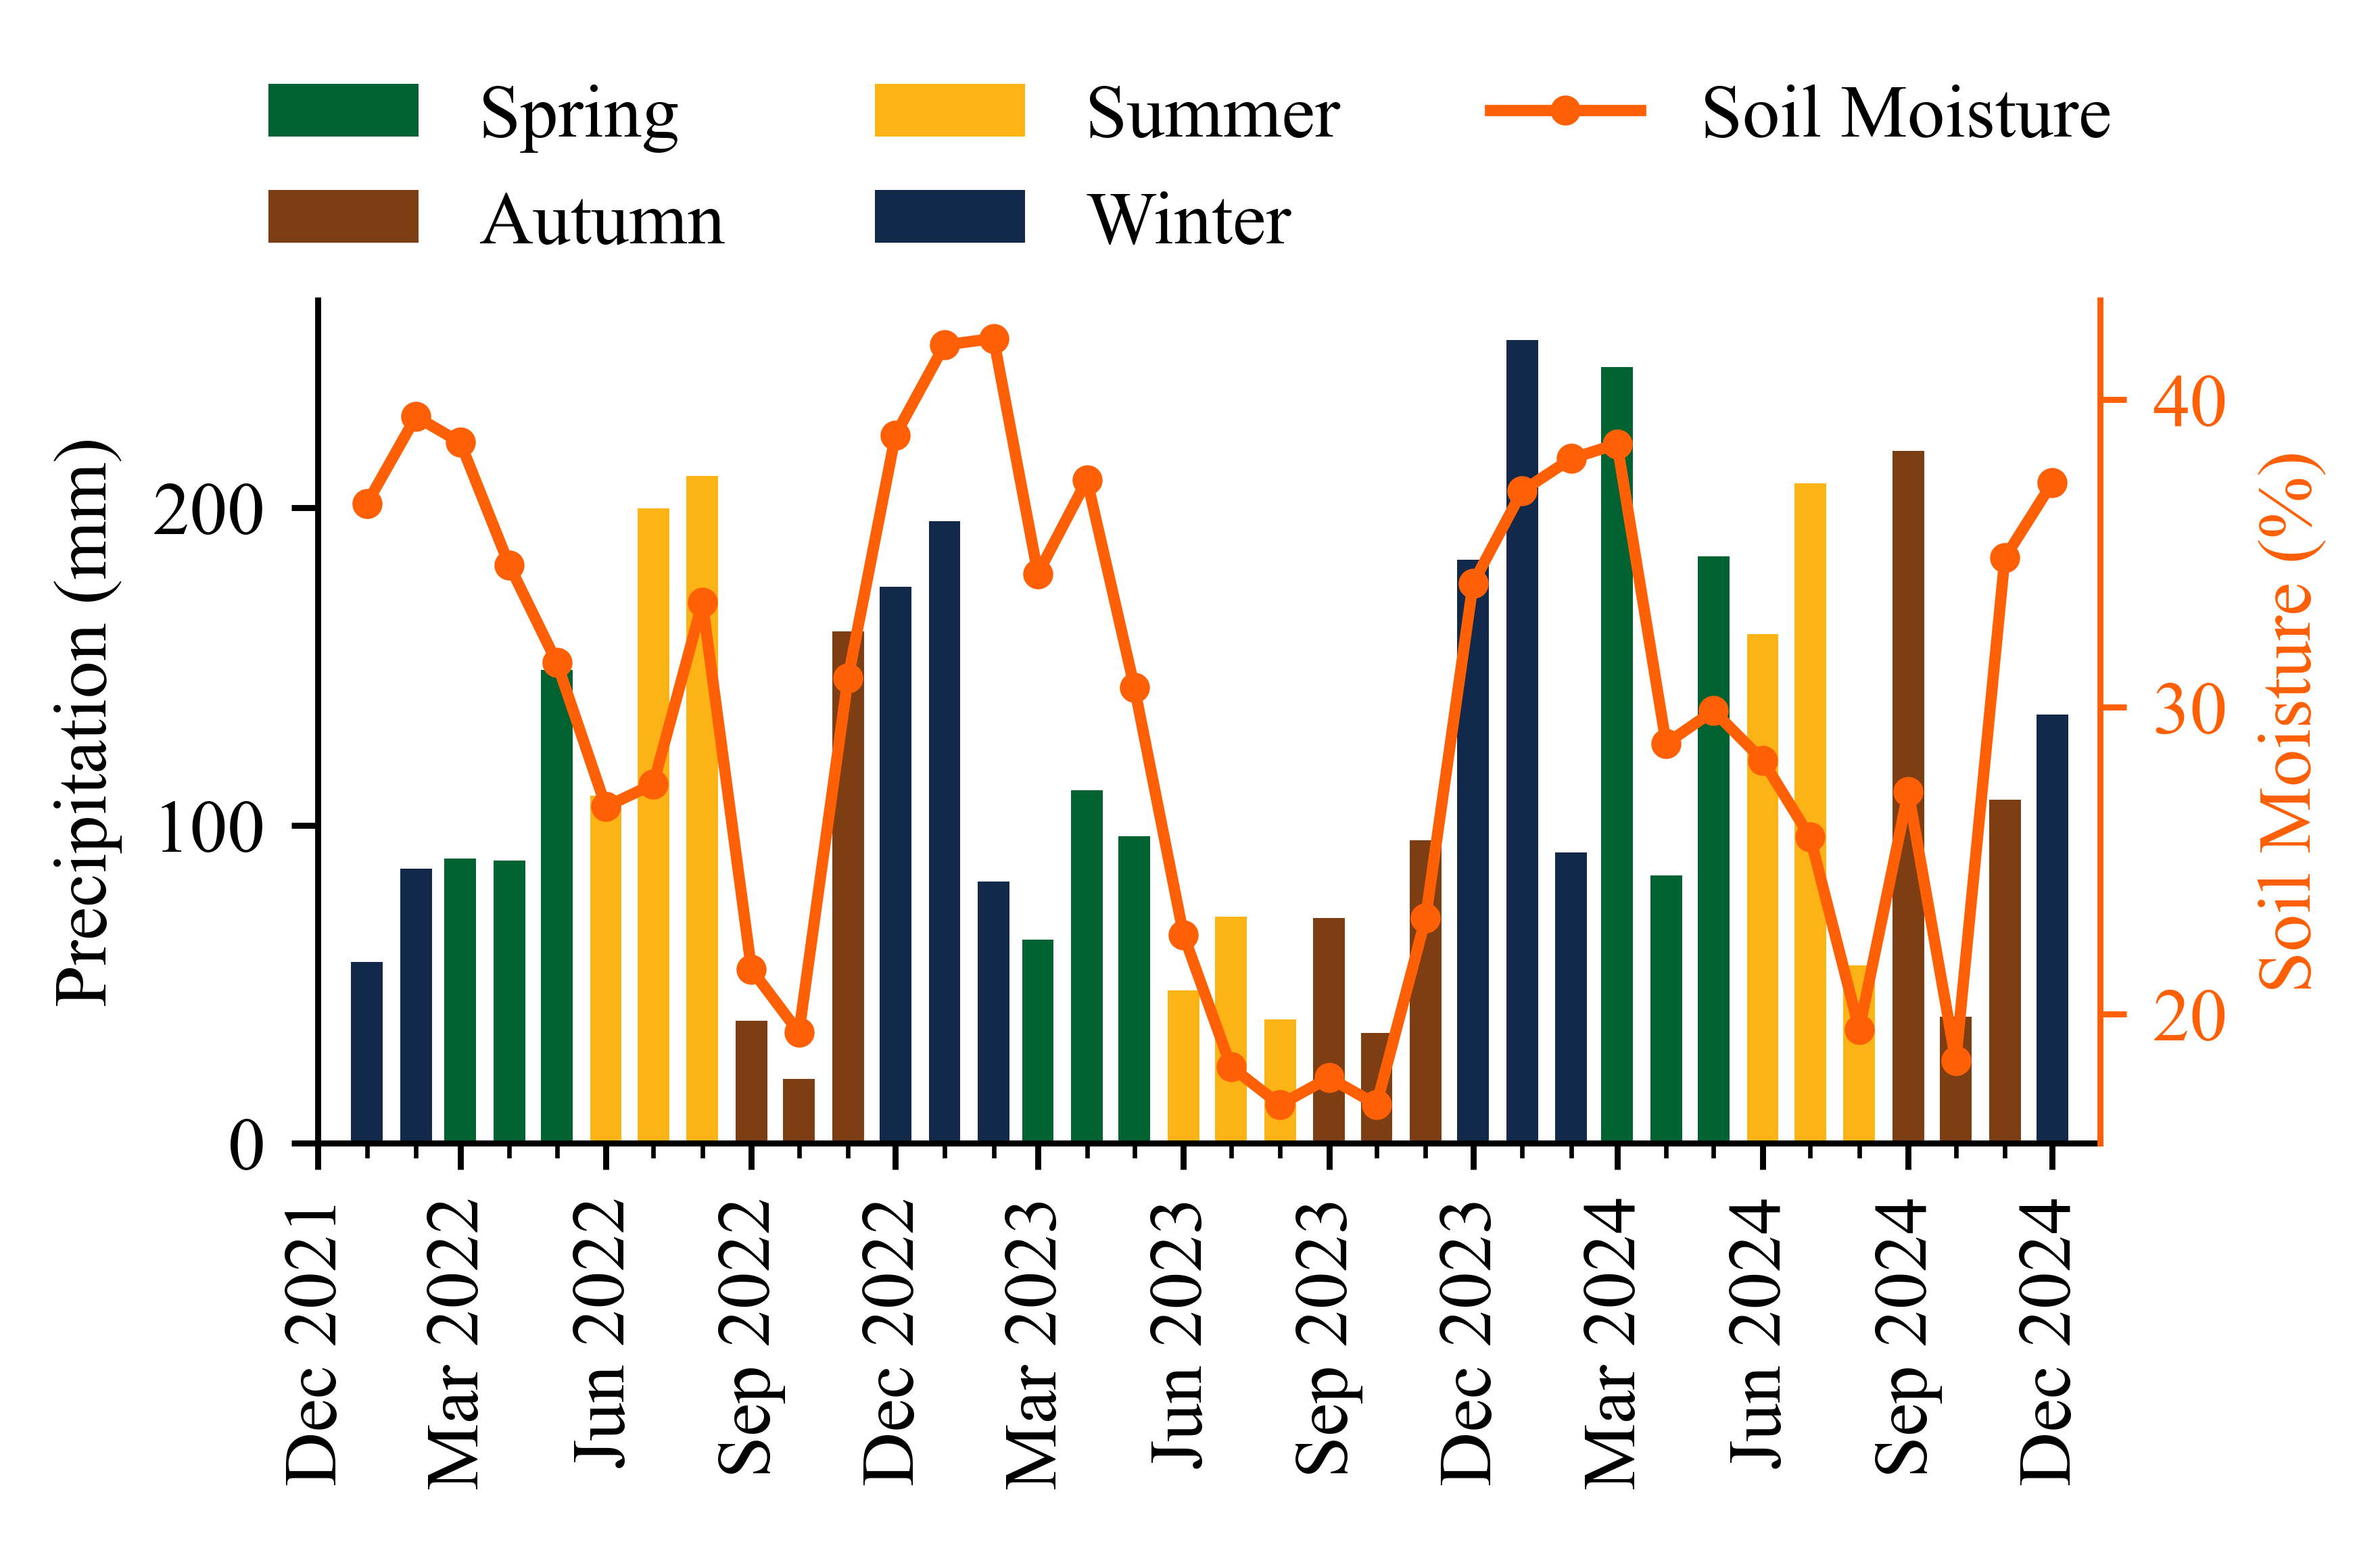

In [9]:
fig, ax = plt.subplots(figsize=(4.5, 2.5), constrained_layout=True)

axt = ax.twinx()
ax.patch.set_visible(False)

for season, group in df_monthly.groupby('season'):
    ax.bar(
        group.index, group['precipitation'],
        color=season_colors[season],
        zorder=-1, width=20, label=season
    )
axt.plot(df_monthly['sm'], zorder=1, lw=1.5, marker='.', label='Soil Moisture')

ax.spines[['top', 'right']].set_visible(False)
axt.spines[['top', 'left', 'bottom']].set_visible(False)
axt.spines['right'].set_visible(True)
axt.spines['right'].set_color('C0')
axt.tick_params(axis='y', colors='C0')

# Add labels
ax.set_ylabel('Precipitation (mm)')
axt.set_ylabel('Soil Moisture (%)', color='C0')

# Set x-axis limits
ax.set_xlim(pd.Timestamp(f'2021-12-01'), pd.Timestamp(f'2024-12-31'))

# Configure x-axis ticks
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[3, 6, 9, 12]))  # Major ticks on Jan, Apr, Aug, Dec
ax.xaxis.set_minor_locator(mdates.MonthLocator())  # Minor ticks on every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as 'Jan 2023'
ax.tick_params(axis='x', which='major', rotation=90)  # Rotate labels 45 degrees

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = axt.get_legend_handles_labels()

handles = handles1 + handles2
labels = labels1 + labels2


order = ['Spring', 'Autumn', 'Summer', 'Winter', 'Soil Moisture']

handles = [handles[labels.index(o)] for o in order]
labels  = [o for o in order]
fig.legend(handles, labels,loc="upper center", ncol=3, frameon=False, bbox_to_anchor=(0.5, 1.15))

fig.tight_layout()

fig.savefig('./figs/monthly_precip_sm.pdf', bbox_inches='tight')

C:\Users\alihg\AppData\Local\Temp\ipykernel_16460\2058196570.py:39: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


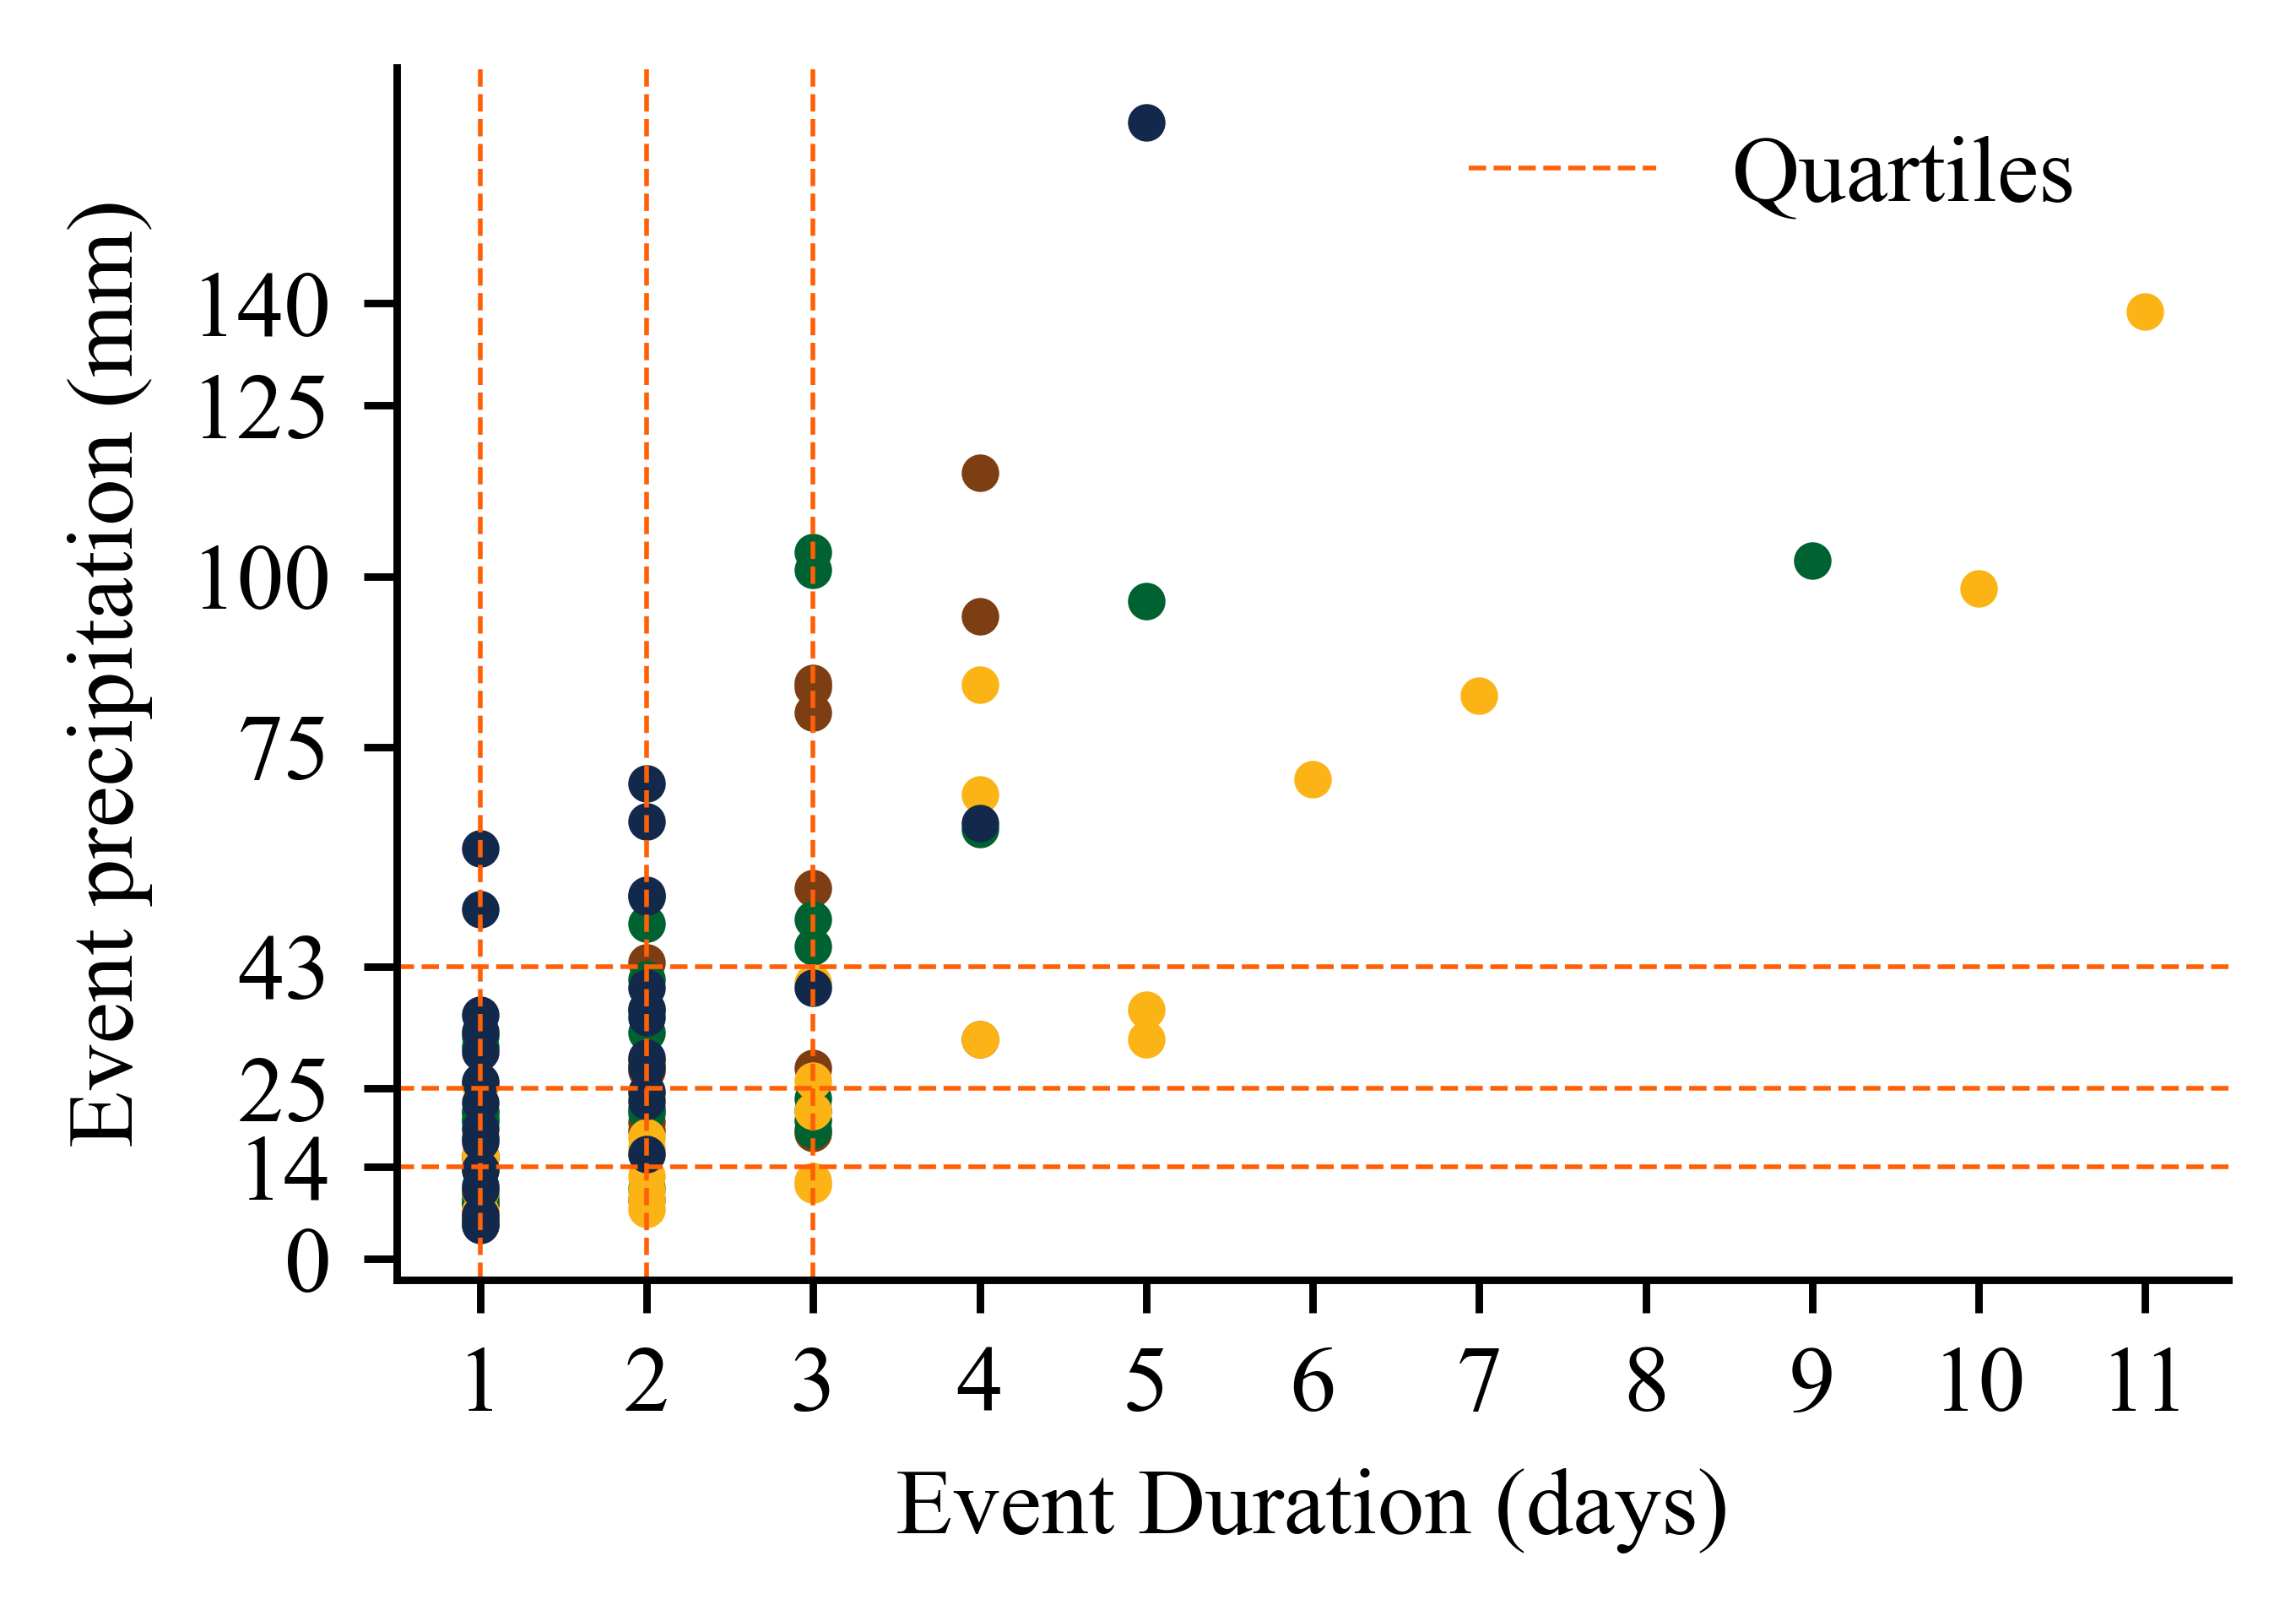

In [10]:
fig, ax = plt.subplots(figsize=(3.5,2.5), constrained_layout=True)

for season, group in events.groupby('season'):
    ax.scatter(
        group['days'], group['total_rain'],
        color=season_colors[season],
        zorder=1, marker='.'
    )

# Quartile reference lines
ax.axhline(events_describe.loc['25%', 'total_rain'], color='C0', label='Quartiles', lw=0.5, ls='--')
ax.axhline(events_describe.loc['50%', 'total_rain'], color='C0', lw=0.5, ls='--')
ax.axhline(events_describe.loc['75%', 'total_rain'], color='C0', lw=0.5, ls='--')
ax.axvline(events_describe.loc['25%', 'days'], color='C0', lw=0.5, ls='--')
ax.axvline(events_describe.loc['50%', 'days'], color='C0', lw=0.5, ls='--')
ax.axvline(events_describe.loc['75%', 'days'], color='C0', lw=0.5, ls='--')

# Style
ax.spines[['top', 'right']].set_visible(False)
ax.set_xticks(np.arange(1, events['days'].max()+1, 1))

yticks = np.sort(np.unique(np.concatenate([
    events_describe.loc[['25%', '50%', '75%'], 'total_rain'],
    np.array([0, 75, 100, 125, 140])
])))
ax.set_yticks(yticks)
ax.set_yticklabels([f"{int(round(y))}" for y in yticks])

ax.set_xlabel('Event Duration (days)')
ax.set_ylabel('Event precipitation (mm)')

# handles, labels = ax.get_legend_handles_labels()
# order = [1, 4, 2, 0, 3]
# handles = [handles[i] for i in order]
# labels = [labels[i] for i in order]

# fig.legend(handles, labels,loc="upper center", ncol=4, frameon=False, bbox_to_anchor=(0.5, 1.095))
fig.legend(loc="upper left", ncol=4, frameon=False, bbox_to_anchor=(0.6, 0.95))
fig.tight_layout()

fig.savefig('./figs/rain events.pdf', bbox_inches='tight')

In [11]:
enriched_events = compute_event_metrics(events, df_soil)
enriched_events = enriched_events[enriched_events['antecedent_sm'].notna()]
enriched_events.tail(3)

,start,end,total_rain,days,season,antecedent_sm,max_sm,delta_sm,lag_days,antecedent_start,antecedent_end,antecedent_time,max_time,post_window_days_used
111,2024-12-04,2024-12-05,28.043888,2,Winter,29.230473,43.154004,13.923531,2.5,2024-12-01,2024-12-03 23:59:59,2024-12-03 18:00:00,2024-12-06 06:00:00,1
112,2024-12-07,2024-12-10,63.865003,4,Winter,40.387379,43.152508,2.765129,4.0,2024-12-06,2024-12-06 23:59:59,2024-12-06 18:00:00,2024-12-10 18:00:00,3
113,2024-12-25,2024-12-25,13.113333,1,Winter,35.774751,43.01777,7.243019,4.0,2024-12-22,2024-12-24 23:59:59,2024-12-24 18:00:00,2024-12-28 18:00:00,3


C:\Users\alihg\AppData\Local\Temp\ipykernel_16460\3850554854.py:154: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(loc="upper center", ncol=4, frameon=False, bbox_to_anchor=(0.5, 1.025))


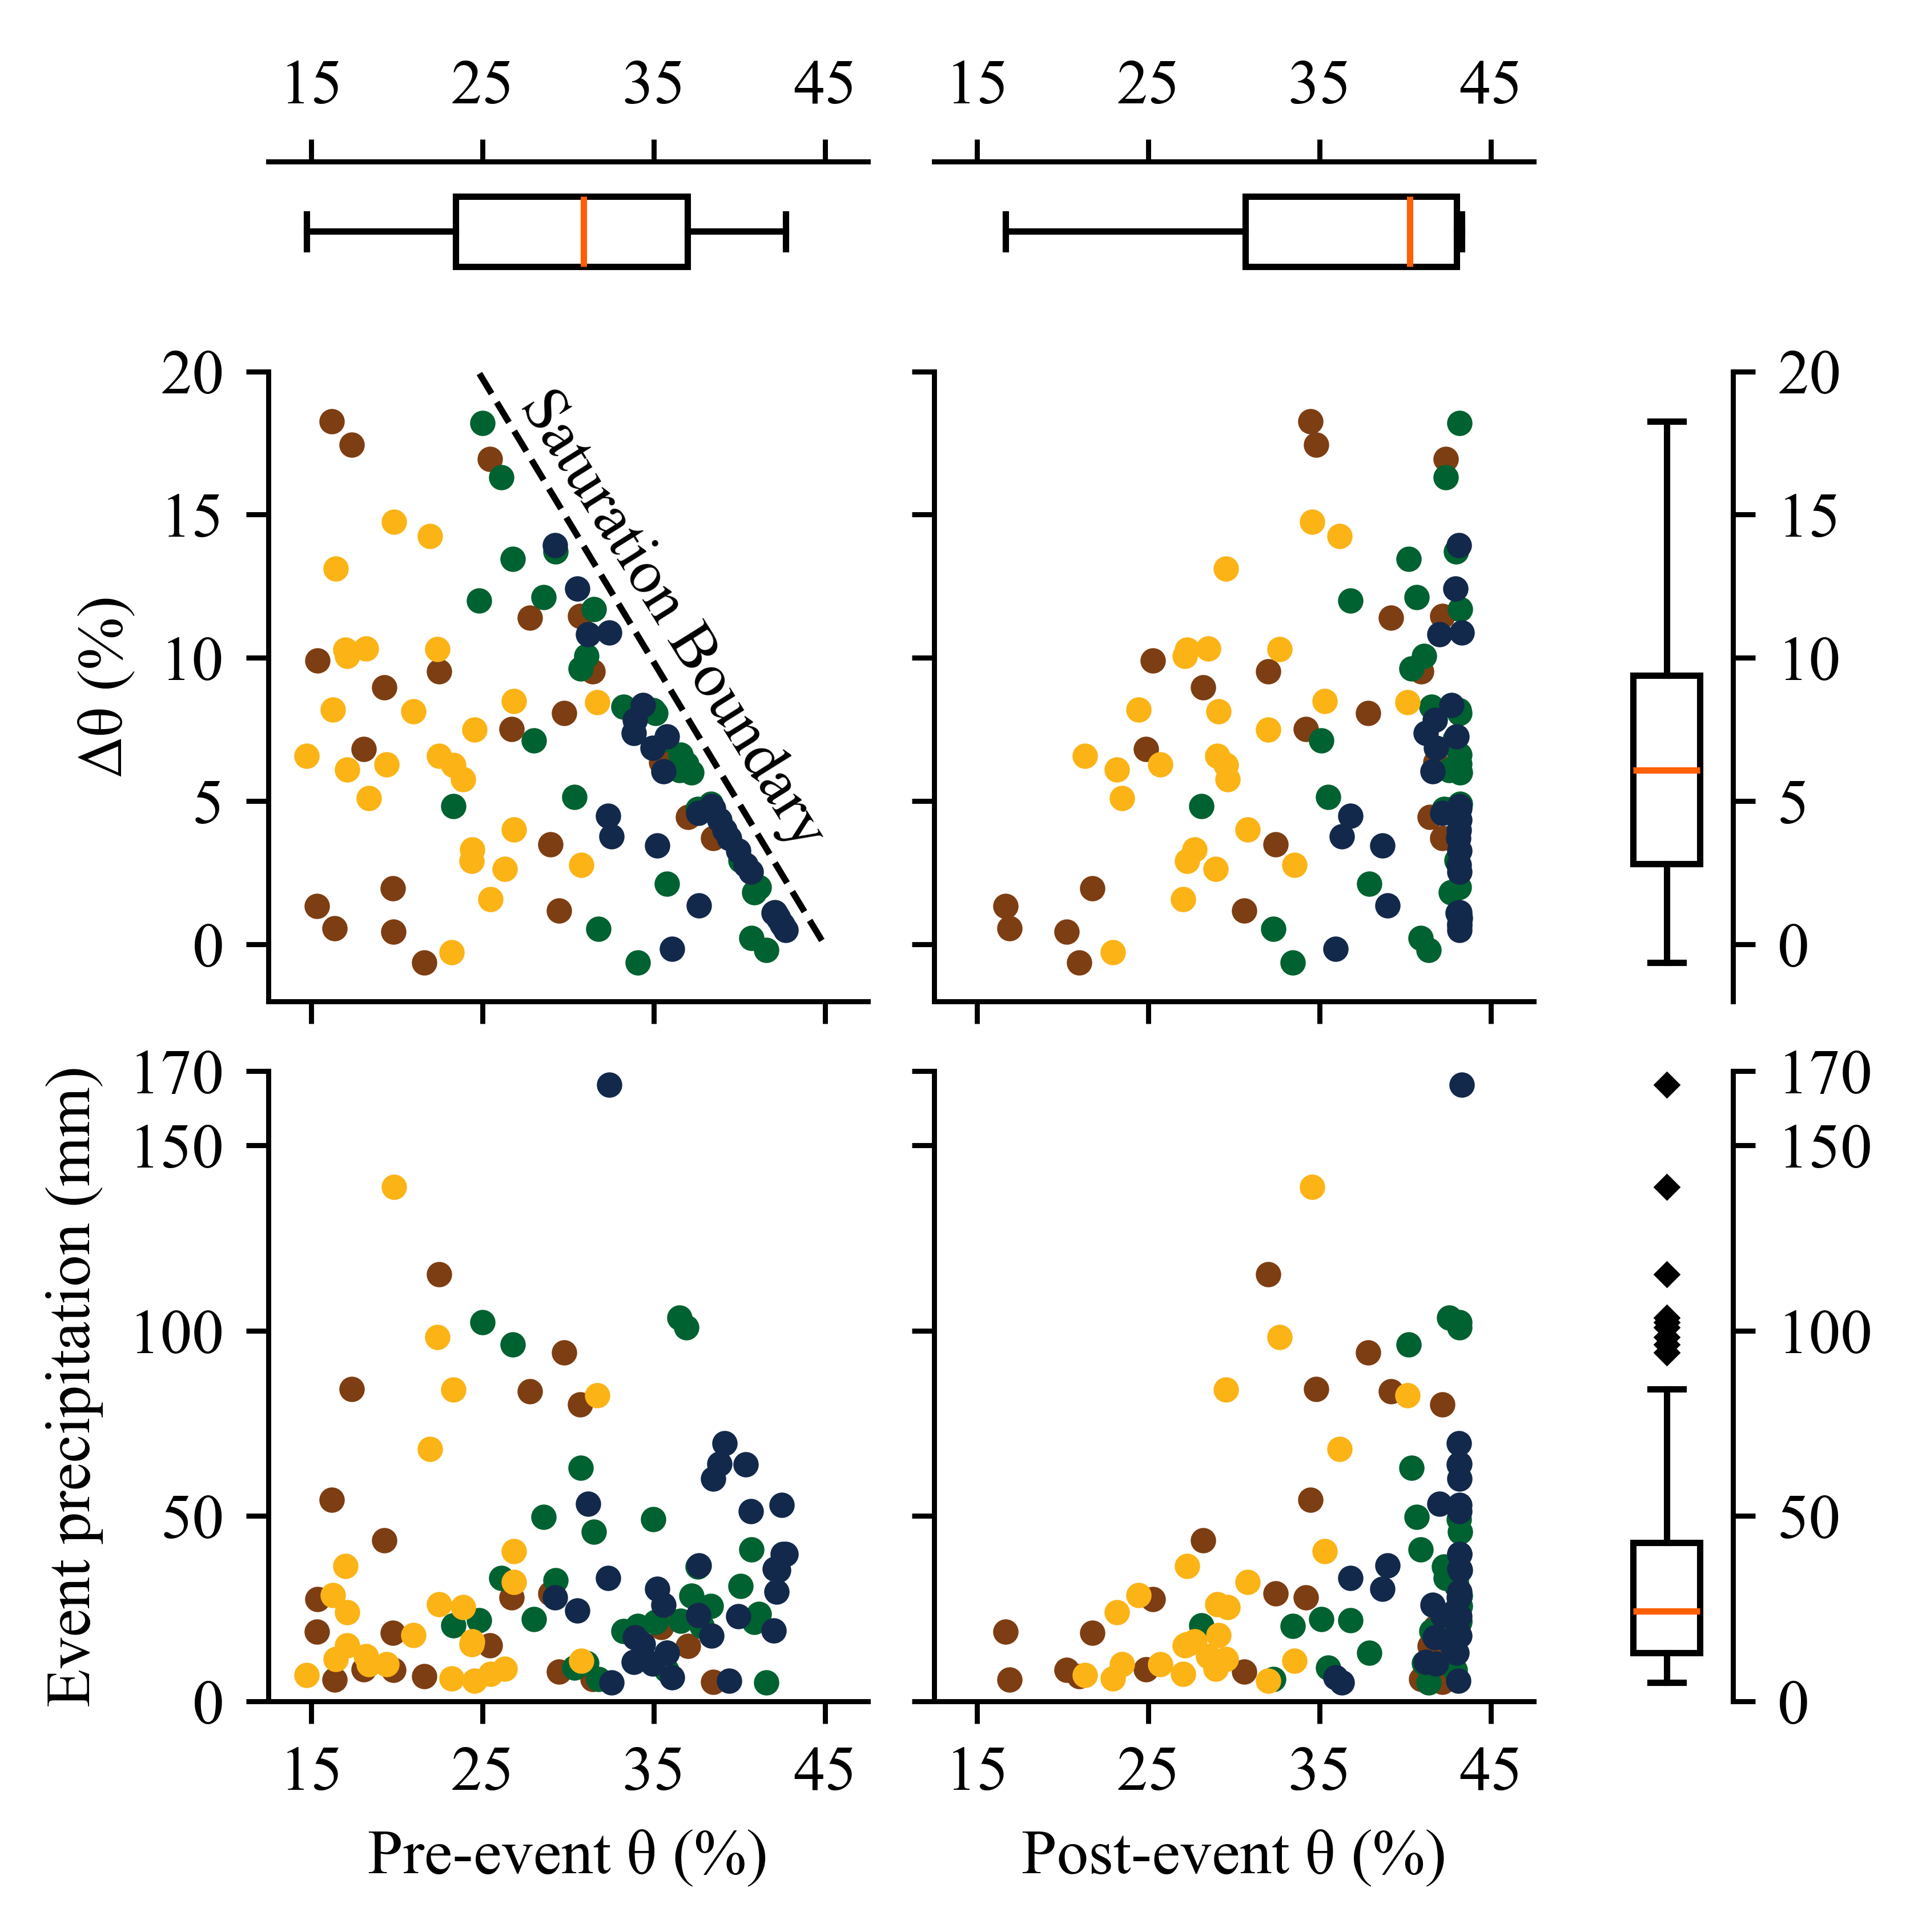

In [19]:
mosaic = [
    ['E','F','N'],
    ['A','B','G'],
    ['X','Y','H'],
]

fig, axs = plt.subplot_mosaic(mosaic,
    empty_sentinel='N',
    gridspec_kw=dict(
        width_ratios=[0.45, 0.45, 0.10],
        height_ratios=[0.10, 0.45, 0.45],
    ),
    figsize=(4, 4)
)

axs['A'].plot(np.linspace(1, 45), -np.linspace(1, 45) * 0.99 + 44.5, color='black', lw=1, ls='--', zorder=0)
angle = np.degrees(np.arctan2(-0.99, 1))
axs['A'].annotate(
    "Saturation Boundary",
    xy=(26.5, 3),
    rotation=-58,
    # rotation_mode='anchor',
    color='black',
    ha='left', va='bottom'
)

for season, group in enriched_events.groupby('season'):
    axs['A'].scatter(
        group['antecedent_sm'], group['delta_sm'],
        color=season_colors[season],
        zorder=1, marker='.'
    )

for season, group in enriched_events.groupby('season'):
    axs['B'].scatter(
        group['max_sm'], group['delta_sm'],
        color=season_colors[season],
        zorder=1, marker='.'
    )

for season, group in enriched_events.groupby('season'):
    axs['X'].scatter(
        group['antecedent_sm'], group['total_rain'],
        color=season_colors[season],
        zorder=1, marker='.'
    )

for season, group in enriched_events.groupby('season'):
    axs['Y'].scatter(
        group['max_sm'], group['total_rain'],
        color=season_colors[season],
        zorder=1, marker='.'
    )

axs['A'].sharey(axs['B'])
axs['B'].tick_params(labelleft=False)
axs['X'].sharey(axs['Y'])
axs['Y'].tick_params(labelleft=False)

axs['A'].sharex(axs['X'])
axs['A'].tick_params(labelbottom=False)
axs['B'].sharex(axs['Y'])
axs['B'].tick_params(labelbottom=False)

axs['E'].boxplot(enriched_events['antecedent_sm'].astype(float),
                 vert=False, patch_artist=True,
                 boxprops=dict(facecolor='white'),
                 medianprops=dict(color='C00'),
                 showfliers=True,
                 positions=[0],   # draw at y=0 instead of y=1
                 flierprops=outlier_props)
axs['E'].set_yticks([])
# axs['E'].margins(x=0)
axs['E'].set_ylim(-0.15, 0.15)   # tighten around the boxplot
axs['E'].xaxis.tick_top()
axs['E'].xaxis.set_label_position("top")
axs['E'].sharex(axs['X'])
axs['E'].spines[['right', 'bottom', 'left']].set_visible(False)

axs['F'].boxplot(enriched_events['max_sm'].astype(float),
                 vert=False, patch_artist=True,
                 boxprops=dict(facecolor='white'),
                 medianprops=dict(color='C00'),
                 showfliers=True,
                 positions=[0],   # draw at y=0 instead of y=1
                 flierprops=outlier_props)
axs['F'].set_yticks([])
# axs['F'].margins(x=0)
axs['F'].set_ylim(-0.15, 0.15)   # tighten around the boxplot
axs['F'].xaxis.tick_top()
axs['F'].xaxis.set_label_position("top")
axs['F'].sharex(axs['Y'])
axs['F'].spines[['right', 'bottom', 'left']].set_visible(False)


axs['G'].boxplot(enriched_events['delta_sm'].astype(float),
                 vert=True, patch_artist=True,
                 boxprops=dict(facecolor='white'),
                 medianprops=dict(color='C00'),
                 showfliers=True,
                 positions=[0],   # draw at y=0 instead of y=1
                 flierprops=outlier_props)
axs['G'].set_xticks([])
# axs['G'].margins(y=0)
axs['G'].set_xlim(-0.15, 0.15)   # tighten around the boxplot
axs['G'].yaxis.tick_right()
axs['G'].yaxis.set_label_position("right")
axs['G'].sharey(axs['A'])
axs['G'].spines[['left', 'bottom', 'top']].set_visible(False)


axs['H'].boxplot(enriched_events['total_rain'].astype(float),
                 vert=True, patch_artist=True,
                 boxprops=dict(facecolor='white'),
                 medianprops=dict(color='C00'),
                 showfliers=True,
                 positions=[0],   # draw at y=0 instead of y=1
                 flierprops=outlier_props)
axs['H'].set_xticks([])
# axs['G'].margins(y=0)
axs['H'].set_xlim(-0.15, 0.15)   # tighten around the boxplot
axs['H'].yaxis.tick_right()
axs['H'].yaxis.set_label_position("right")
axs['H'].sharey(axs['X'])
axs['H'].spines[['left', 'bottom', 'top']].set_visible(False)

theta_x_ticks = [15, 25, 35, 45]
axs['X'].set_xlim([12.5, 47.5])
axs['X'].set_xticks(theta_x_ticks)
axs['Y'].set_xticks(theta_x_ticks)
axs['Y'].set_xlim([12.5, 47.5])
axs['X'].set_xticklabels([round(x) for x in theta_x_ticks])
axs['Y'].set_xticklabels([round(x) for x in theta_x_ticks])
axs['A'].set_ylim([-2, 20])
axs['A'].set_yticks([0, 5, 10, 15, 20])
axs['A'].set_yticklabels([0, 5, 10, 15, 20])
axs['X'].set_ylim([0, 170])
axs['X'].set_yticks([0, 50, 100, 150, 170])


# Style
for key, ax in axs.items():
    ax.spines[['top', 'right']].set_visible(False)
axs['E'].spines[['top']].set_visible(True)
axs['F'].spines[['top']].set_visible(True)
axs['G'].spines[['right']].set_visible(True)
axs['H'].spines[['right']].set_visible(True)

axs['X'].set_xlabel('Pre-event θ (%)')
axs['Y'].set_xlabel('Post-event θ (%)')
axs['A'].set_ylabel('Δθ (%)')
axs['X'].set_ylabel('Event precipitation (mm)')

fig.legend(loc="upper center", ncol=4, frameon=False, bbox_to_anchor=(0.5, 1.025))

fig.tight_layout(pad=0)

fig.subplots_adjust(hspace=0.15, wspace=0.15)

fig.savefig('./figs/dt events.pdf', bbox_inches='tight')

In [13]:
enriched_events.astype({
    'antecedent_sm': 'float',
    'max_sm': 'float',
    'delta_sm': 'float',
    'total_rain': 'float'
})[['antecedent_sm', 'max_sm', 'delta_sm', 'total_rain']].describe()

,antecedent_sm,max_sm,delta_sm,total_rain
count,110.000000,110.000000,110.000000,110.000000
mean,30.116985,36.489170,6.372185,34.769029
std,8.156877,7.431012,4.573996,31.238423
min,14.736711,16.659605,-0.647276,5.039999
25%,23.440787,30.667800,2.797753,13.063333
50%,30.914367,40.289216,6.078434,24.292220
75%,36.974871,43.006547,9.376560,42.839583
max,42.713566,43.306302,18.264852,166.432767


In [14]:
# enriched_events[enriched_events['lag_days']<=1].sort_values('delta_sm', ascending=False)
# enriched_events.loc[:, ['delta_sm']].max()

In [15]:
sel = enriched_events.iloc[88:93]
sel = enriched_events.iloc[82:90].drop(89)
sel = enriched_events.iloc[82:90]
sel = enriched_events.loc[33:36]
sel = enriched_events.loc[60:65]

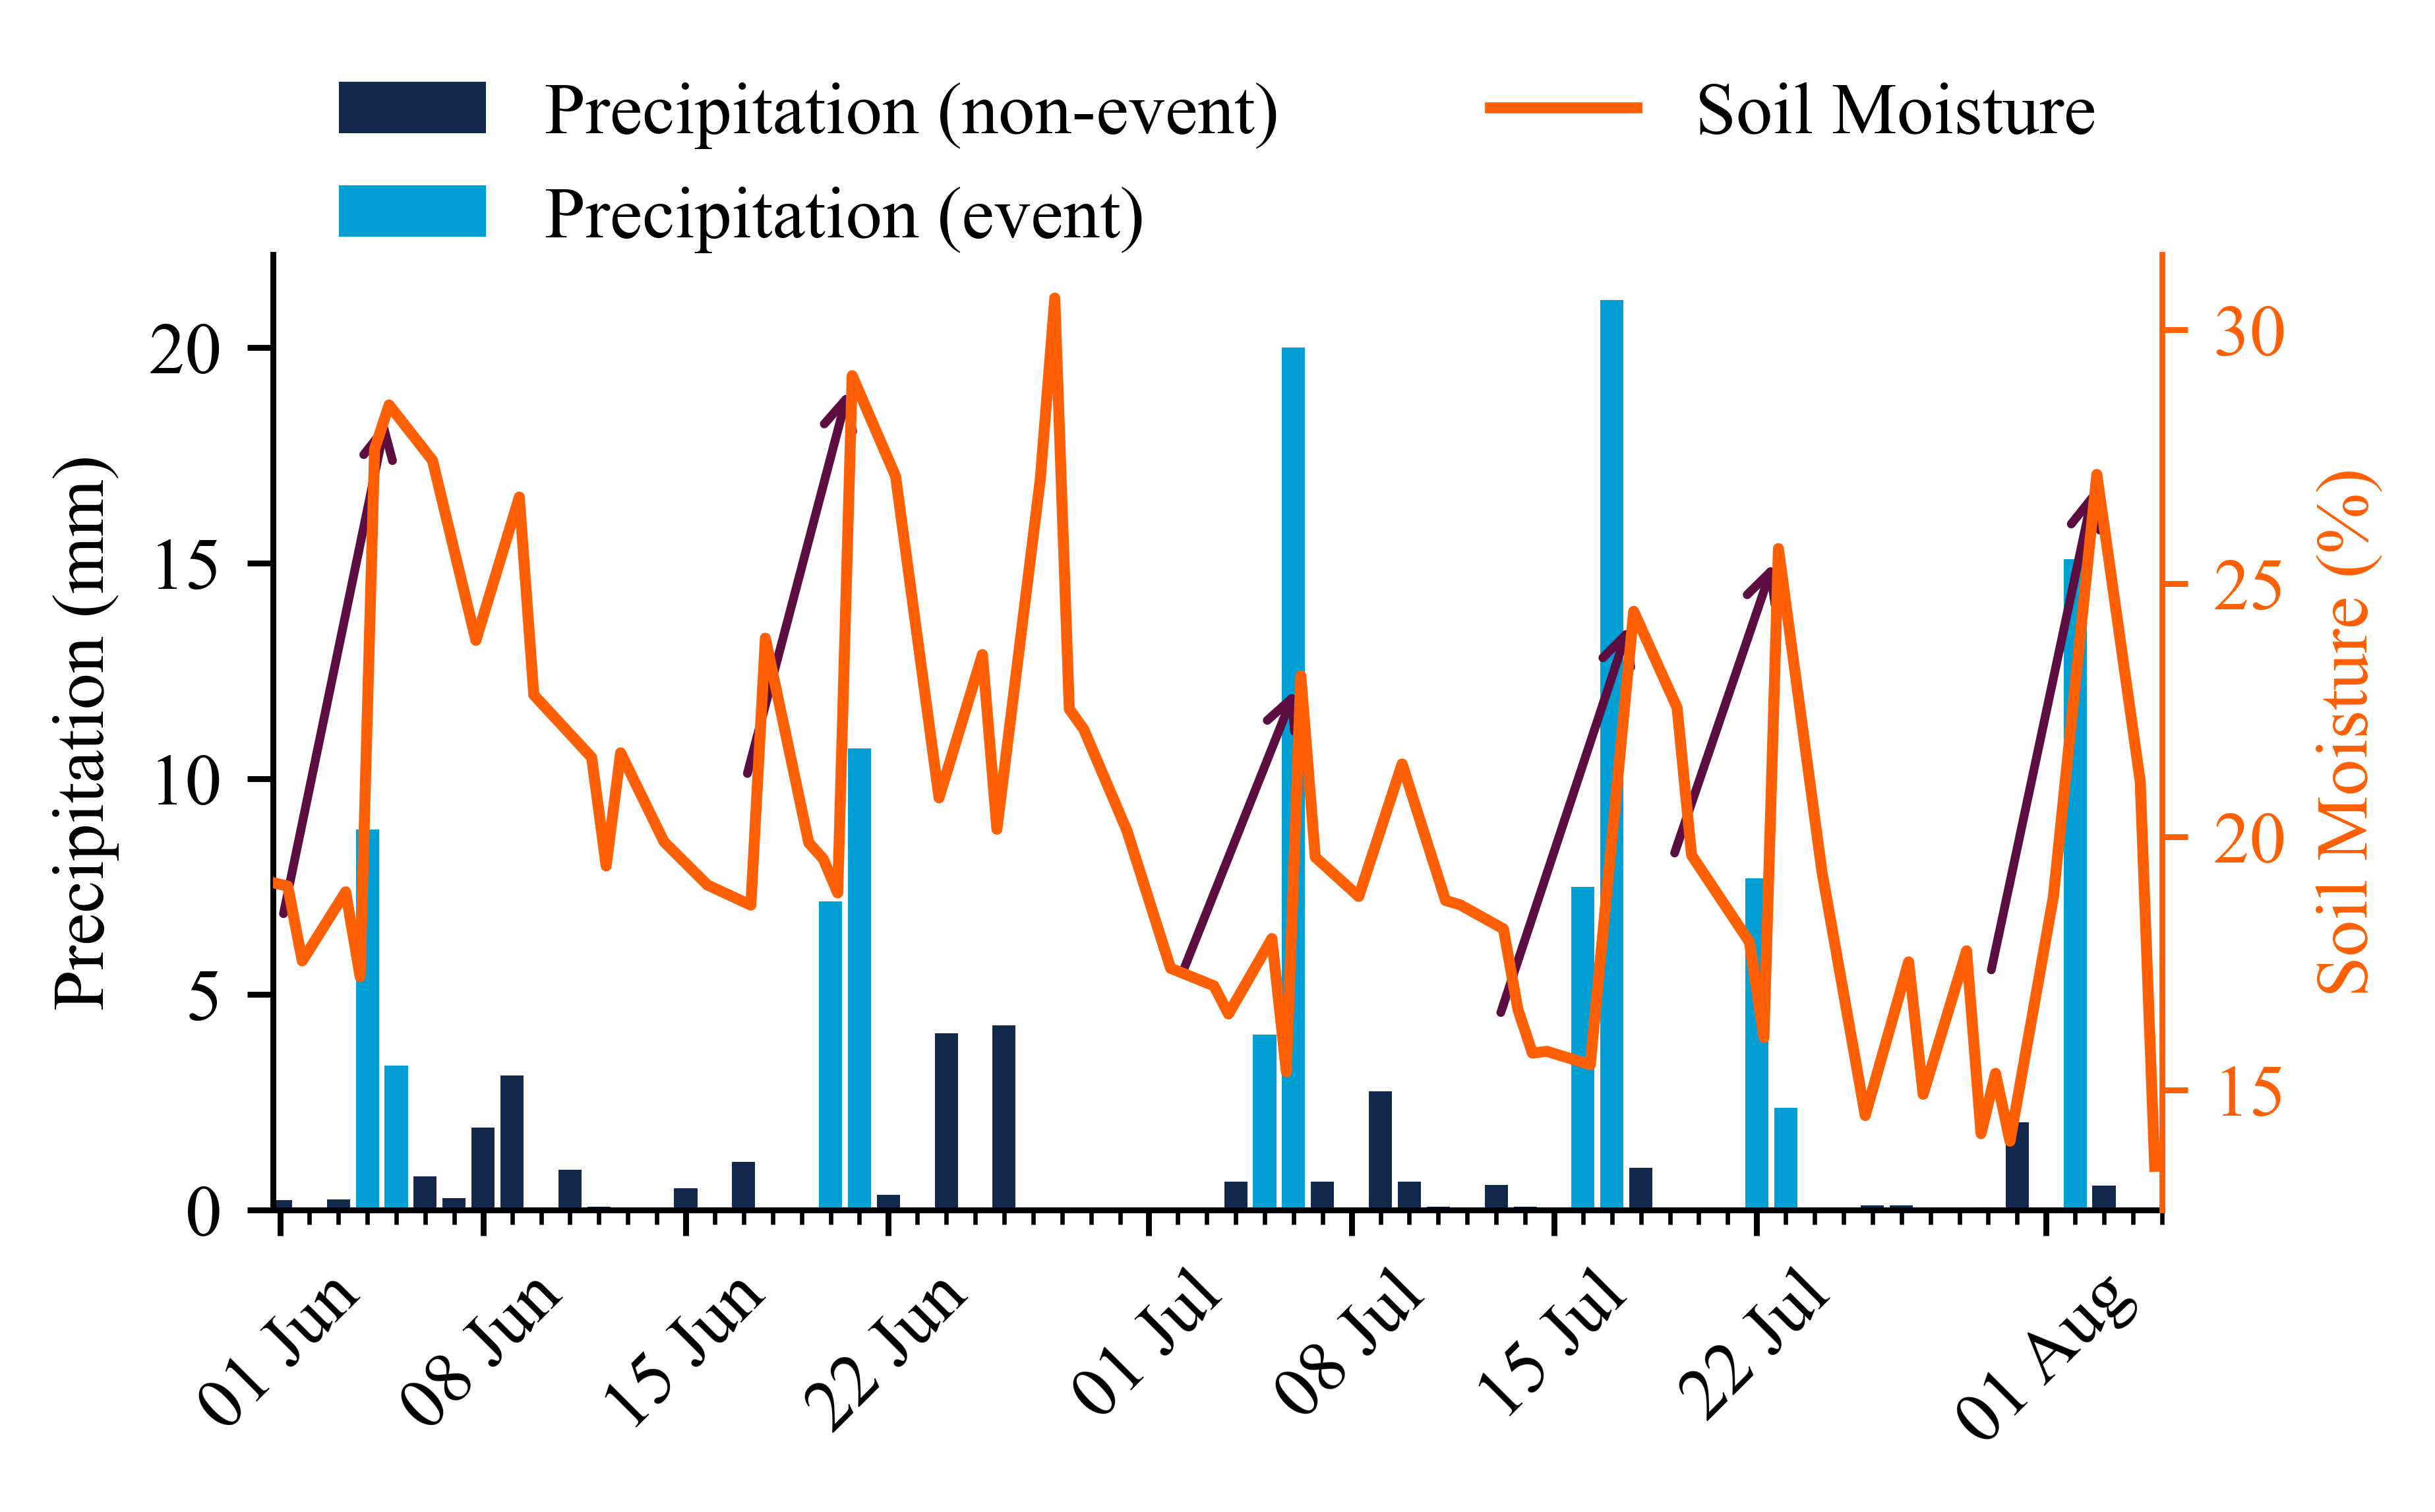

In [16]:
window_start = sel['antecedent_time'].min() - pd.Timedelta(days=3)
window_end   = sel['end'].max() + pd.Timedelta(days=3)

rain_win = df_rain.loc[(df_rain.index >= window_start) & (df_rain.index <= window_end)]
soil_win = df_soil.loc[(df_soil.index >= window_start) & (df_soil.index <= window_end)]

event_mask = pd.Series(False, index=rain_win.index)
for _, r in sel.iterrows():
    event_mask |= (rain_win.index >= r['start']) & (rain_win.index <= r['end'])

bar_colors = np.where(event_mask, 'C2', 'C1')

fig, ax = plt.subplots(figsize=(4.5, 2.75), constrained_layout=True)
axt = ax.twinx()
ax.patch.set_visible(False)

ax.bar(rain_win.index, rain_win['precipitation'], color=bar_colors)
axt.plot(soil_win.index, soil_win['sm'], label='Soil Moisture', c='C0')

# ARROWS START
if 89 in sel.index:
    sel = sel.drop(89)
for _, r in sel.iterrows(): ### DROPPPED 89 LOOK AT ME 
    x0 = pd.to_datetime(r['antecedent_start'])
    y0 = float(r['antecedent_sm'])
    x1 = pd.to_datetime(r['max_time'])
    y1 = float(r['max_sm'])

    axt.annotate(
        '',  # no text, just an arrow
        xy=(x1, y1),
        xytext=(x0, y0),
        arrowprops=dict(arrowstyle='->', lw=1.2, color='C6'),
        zorder=-1
    )

chosen_i = 63  # <- change to pick which row in `sel` to annotate
r = sel.loc[chosen_i]

x0 = pd.to_datetime(r['antecedent_start'])
y0 = float(r['antecedent_sm'])
x1 = pd.to_datetime(r['max_time'])
y1 = float(r['max_sm'])


# axt.text(
#     x1 - pd.Timedelta(hours=190),  # small right shift
#     y1-0.02,
#     f'θΔ = {round(r["delta_sm"]*100)}%',
#     va='center', ha='left', fontsize=10, color='C6'
# )
# ARROWS END


ax.spines[['top', 'right']].set_visible(False)
axt.spines[['top', 'left', 'bottom']].set_visible(False)
axt.spines['right'].set_visible(True)
axt.spines['right'].set_color('C0')
axt.tick_params(axis='y', colors='C0')

ax.set_ylabel('Precipitation (mm)')
axt.set_ylabel('Soil Moisture (%)', color='C0')

ax.set_xlim(window_start, window_end)
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
ax.tick_params(axis='x', which='major', rotation=45)

handles = [Patch(facecolor='C1', label='Precipitation (non-event)'),
           Patch(facecolor='C2', label='Precipitation (event)')]
leg1 = ax.legend(handles=handles, loc="upper left", frameon=False, bbox_to_anchor=(0, 1.25))
leg2 = axt.legend(loc="upper right", frameon=False, bbox_to_anchor=(1, 1.25))

fig.savefig('./figs/sample events.pdf', bbox_inches='tight')

In [17]:
# for index, sample_row in enriched_events.iterrows():
    
#     fig, ax = plt.subplots(figsize=(4.5, 2.5), constrained_layout=True)

#     axt = ax.twinx()
#     ax.patch.set_visible(False)

#     ax.bar(df_rain.index, df_rain.loc[:, 'precipitation'], label='Precipitation', color='C1')
#     axt.plot(df_soil[nan_filter].index, df_soil[nan_filter].loc[:, 'sm'], marker='.', label='Soil Moisture', c='C0')

#     ax.spines[['top', 'right']].set_visible(False)
#     axt.spines[['top', 'left', 'bottom']].set_visible(False)
#     axt.spines['right'].set_visible(True)
#     axt.spines['right'].set_color('C0')
#     axt.tick_params(axis='y', colors='C0')

#     axt.axhline(sample_row['antecedent_sm'], color='C0', lw=0.5, ls='-', label='Antecedent SM', c='C03')
#     axt.axhline(sample_row['max_sm'], color='C0', lw=0.5, ls='-', label='Max SM', c='C02')
#     axt.axvline(sample_row['antecedent_time'], color='C03', lw=0.5, ls='-',)
#     axt.axvline(sample_row['max_time'], color='C02', lw=0.5, ls='-',)


#     # Add labels
#     ax.set_ylabel('Precipitation (mm)')
#     axt.set_ylabel('Soil Moisture (m³/m³)', color='C0')

#     # Set x-axis limits
#     ax.set_xlim(sample_row['start'] - pd.Timedelta(days=5),
#                 sample_row['end'] + pd.Timedelta(days=5))
#     ax.xaxis.set_minor_locator(mdates.DayLocator())   # Minor ticks every day
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))  # Format as '01 Aug'
#     ax.tick_params(axis='x', which='major', rotation=45)  # Rotate labels 45 degrees

#     fig.legend(loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.15))

#     fig.tight_layout()

#     fig.savefig(f'./figs/events/{index}.png', bbox_inches='tight')